In [1]:
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim
import os
import sys

In [2]:
import numpy as np

In [3]:
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

In [4]:
sys.path.append('../src')
from DeepGenerativeModels.AutoEncoders import FlowVAE, VAE
from DeepGenerativeModels.RealNVP import RealNVP

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)

/home/tamazgadaev/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/tamazgadaev/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/tamazgadaev/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/tamazgadaev/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# Обучение

## FlowVAE

In [32]:
class FlowVAE(VAE):
    def __init__(self, latent_dim, input_dim, flows_number, hidden_dim=200, device='cpu'):
        """
        Standart model of VAE with ELBO optimization.
        Input: latent_dim,  int     - the dimension of latent space.
        Input: input_dim,   int     - the dimension of input space.
        Input: device,      string  - the type of computing device: 'cpu' or 'gpu'.
        Input: hidden_dim,  int     - the size of hidden_dim neural layer.
        """
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.device = device
        self.flows_number = flows_number
        self.flows = nn.ModuleList([RealNVP(dim=latent_dim) for i in range(flows_number)])
        self.proposal_z = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.LeakyReLU(),
        )
        self.proposal_mu = nn.Linear(hidden_dim, self.latent_dim)
        self.proposal_sigma = nn.Linear(hidden_dim, self.latent_dim)

        self.generative_network = nn.Sequential(
            nn.Linear(self.latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, self.input_dim),
            nn.Sigmoid()
        )

        self.to(device)


    def loss(self, batch_x, batch_y):
        """
        Calculate ELBO approximation of log likelihood for given batch with negative sign.
        Input: batch_x, FloatTensor - the matrix of shape batch_size x input_dim.
        Input: batch_y, FloatTensor - dont uses parameter in this model.

        Return: Tensor - scalar, ELBO approximation of log likelihood for given batch with negative sign.
        """
        batch_x = batch_x.to(self.device)
        batch_y = batch_y.to(self.device)
        batch_size = batch_x.shape[0]

        propos_distr = self.q_z(batch_x)
        pri_distr = self.p_z(batch_size)
        z = self.sample_z(propos_distr).view(-1, self.latent_dim)
        
        zk, log_det = self.apply_flows(z)
        x_distr = self.q_x(zk)

        expectation = torch.mean(
            self.log_mean_exp(
                self.log_likelihood(
                    batch_x, x_distr)), dim=0)

        divergence = self.divergence_KL_normal(propos_distr, pri_distr)

        return -1 * torch.mean(expectation - divergence - log_det, dim=0)
                                   
    
    def apply_flows(self, z):
        """
        Return the output of sequence of flows
        Input: z, FloatTensor - the matrix of shape batch_size x latent_dim.
        
        Return: FloatTensor - matrix of shape batch_size x latent_dim.
        """     
        log_det = 0.
        for i, flow in enumerate(self.flows):
            if i == 0:
                zk, log_det_k = flow(z)
            else:
                zk, log_det_k = flow(zk)
            log_det = log_det + log_det_k
        return zk, log_det
                                   
                                   
    def posterior_z(self, z, x):
        """
        Return margin distribution of Z
        Input: x, FloatTensor - the matrix of shape 1 x input_dim.
        Input: z, FloatTensor - the matrix of shape 1 x latent_dim.
        
        Return: FloatTensor - matrix of shape 1 x batch_size_x.
        """
        z = z.to(self.device)
        zk, log_det = self.apply_flows(z)
        x = x.to(self.device)

        mu, sigma = self.q_z(x)
        
        mn = torch.distributions.MultivariateNormal(mu, covariance_matrix=torch.eye(sigma.shape[-1])*(sigma))
        log_proba = mn.log_prob(z) - log_det    
        return log_proba


    def generate_samples(self, num_samples):
        """
        Generate samples of object x from noises in latent space.
        Input: num_samples, int - the number of samples, wich need to generate.

        Return: Tensor - the matrix of shape num_samples x input_dim.
        """
        distr_z = self.p_z(num_samples=1)

        z = self.sample_z(distr, num_samples=num_samples)
        z, _ = self.apply_flows(z)

        distr_x = self.q_x(z).view([num_samples, -1])

        return torch.bernoulli(distr_x, device = self.device)

In [8]:
import utils

In [46]:
flow_vae_model = FlowVAE(2, 28*28, 2, device=device)
vae_model = VAE(2, 28*28, device=device)

In [59]:
optimizer = optim.Adam(vae_model.parameters(), lr=0.001)
utils.trainer(model = vae_model, 
        optimizer = optimizer, 
        dataset = train_data, 
        count_of_epoch = 5,
        batch_size = 128,              
        callback = None,
        progress = tqdm)

In [47]:
optimizer = optim.Adam(flow_vae_model.parameters(), lr=0.001)
utils.trainer(model = flow_vae_model, 
        optimizer = optimizer, 
        dataset = train_data, 
        count_of_epoch = 15,
        batch_size = 128,
        callback = None,
        progress = tqdm)

## VAE

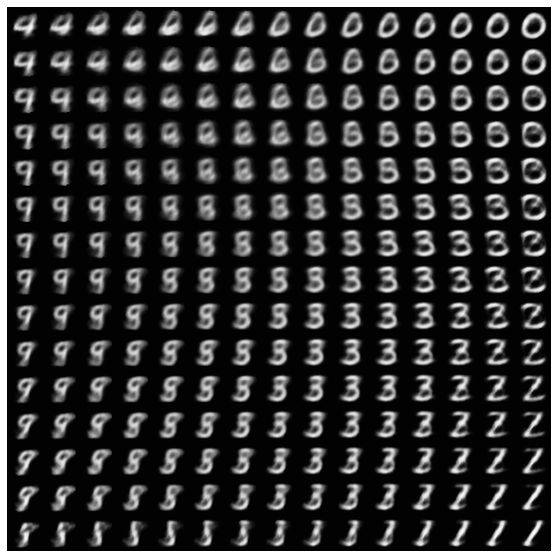

In [60]:

figure = utils.draw_samples_grid_vae(vae_model)

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
plt.axis('off')
plt.show()

## FlowVAE

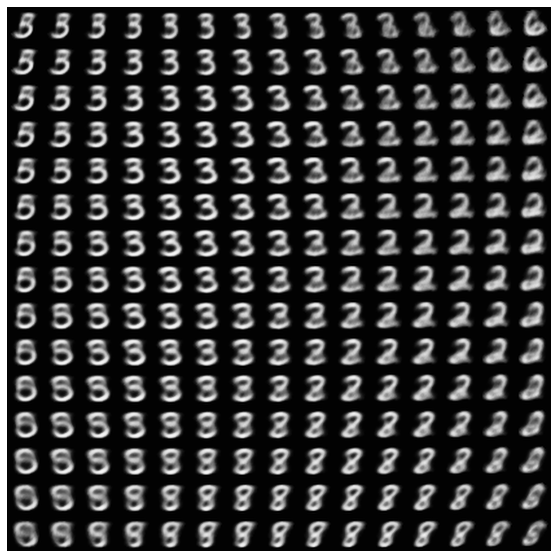

In [48]:
figure = utils.draw_samples_grid_vae(flow_vae_model)

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
plt.axis('off')
plt.show()

# Draw posterior

In [49]:
batch_x, batch_y = list(DataLoader(train_data))[0]

In [56]:
x = np.linspace(-3, 3.0, 100)
y = np.linspace(-3, 3.0, 100)

vae_model = vae_model.to(torch.device('cpu'))
vae_model.device = torch.device('cpu')
flow_vae_model = flow_vae_model.to(torch.device('cpu'))
flow_vae_model.device = torch.device('cpu')

xx, yy = np.meshgrid(x, y)

probas1 = np.zeros(xx.shape)
probas2 = np.zeros(xx.shape)

for i in tqdm(range(xx.shape[0])):
    for j in range(xx.shape[1]):
        z = torch.Tensor([xx[i,j], yy[i,j]]).view([1, -1])
        probas1[i, j] = vae_model.posterior_z(z, batch_x)
        probas2[i, j] = flow_vae_model.to('cpu').posterior_z(z, batch_x)

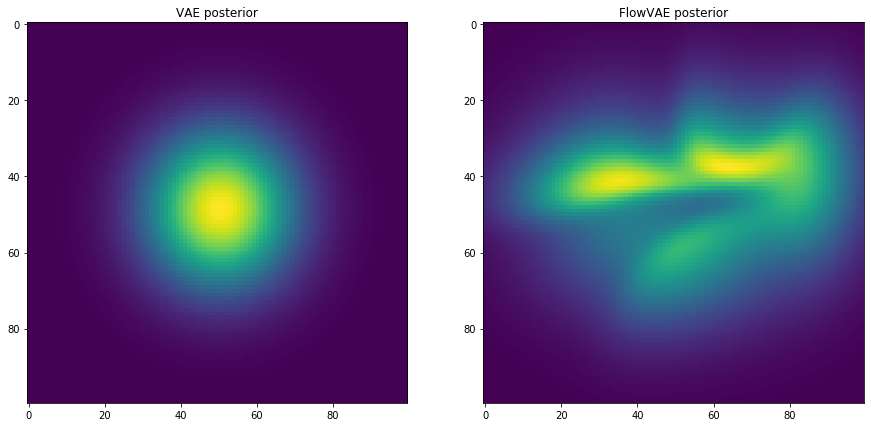

In [61]:
plt.rcParams['figure.figsize'] = (15, 8)
fig, axes = plt.subplots(1,2)
axes[0].imshow(probas1)
axes[0].set_title('VAE posterior')
axes[1].imshow(np.exp(probas2))
axes[1].set_title('FlowVAE posterior')
plt.show()